In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import ipdb

# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead

from Utils.transformations import transform_to_canvas, transform_to_grid

# Visualization tools:
from Visualization.visz_pointcloud_w_label import plot_point_cloud_with_bboxes_o3d


print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
#train_pointclouds_full_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne'

train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# TODO: Add Loader for test set (No labels)

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)

# TODO: Load anchors:



Visualize a pointcloud with its annotations

In [3]:
# Example usage:
random_idx_sample = random.randint(0,7000)
point_cloud, labels = train_set[random_idx_sample]  # TODO: Is it necessary to rotate bounding box 90 deg?
geometries = plot_point_cloud_with_bboxes_o3d(point_cloud.numpy(), labels)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006260.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


Batch data:

In [4]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    
    # Convert lists of point clouds and annotations into tensors
    point_clouds = torch.stack(point_clouds, dim=0)
    
    # Padding for variable-sized labels:
    max_annotations = max(len(a['Car']) for a in annotations)
    padded_annotations = []
    for a in annotations:
        # Pad each annotation to have max_annotations entries
        car_annotations = a['Car'] + [{}] * (max_annotations - len(a['Car']))
        padded_annotations.append({'Car': car_annotations})
    
    return point_clouds, padded_annotations

        
# Create the dataset and DataLoader
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir, device=device, kitti_dataset=train_set, aug_dim=AUG_DIM, max_points_in_pillar=MAX_POINTS_PER_PILLAR,
                             max_pillars=MAX_FILLED_PILLARS, x_min=X_MIN, y_min=Y_MIN, z_min=Z_MIN, x_max = X_MAX, y_max=Y_MAX,
                             z_max = Z_MAX, pillar_size=PILLAR_SIZE)

train_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)


# Iterate through batches:  
for batch_idx, (pseudo_image, label) in enumerate(train_loader):
    break # TODO: Erase this and load the entire dataset

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin
Loading point cloud number 0
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/004407.bin
Loading point cloud number 1
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/002395.bin
Loading point cloud number 2
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/005517.bin
Loading point cloud number 3


Text(0.5, 1.0, 'Features Summed Over Channels')

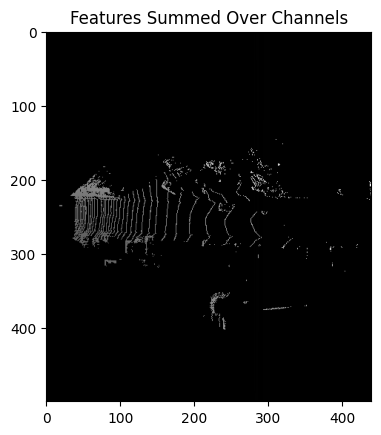

In [5]:
pseudo_image.size()
# Sum over channels for the original features
pseudo_image_raw = torch.sum(pseudo_image[0, :, :, :], dim=0).detach().numpy()
plt.imshow(pseudo_image_raw, cmap='gray')
plt.title('Features Summed Over Channels')

In [6]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

Text(0.5, 1.0, 'Features Summed Over Channels')

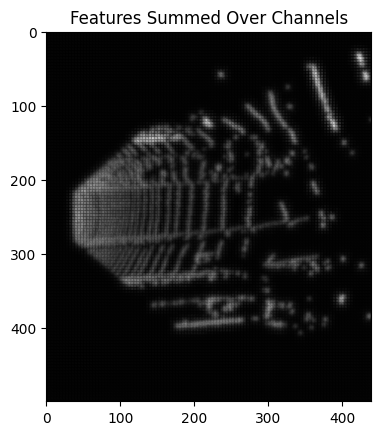

In [7]:
# Forward pass through the backbone:

backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_image)


# Sum over channels for the original features
backbone_raw = torch.sum(backbone_features[3, :, :, :], dim=0).detach().numpy() # FIXME: Hardcoded batch_size
plt.imshow(backbone_raw, cmap='gray')
plt.title('Features Summed Over Channels')

Now, implement the Detection Head:

In [8]:
#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(device=device, in_channels=backbone_features.size()[1], grid_size_x=backbone_features.size()[2], 
                        grid_size_y=backbone_features.size()[3], num_anchors=4, num_classes=2) #TODO: Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

Create anchors for Single-Shot Detector:

Now, create the loss function:

In [ ]:

class PointPillarLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(PointPillarLoss, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Unpack predictions and targets
        pred_boxes, pred_scores = predictions
        gt_boxes, gt_scores = targets
        
        # Calculate the residuals for the boxes
        da = torch.sqrt((pred_boxes[:, 3] - pred_boxes[:, 0])**2 + (pred_boxes[:, 4] - pred_boxes[:, 1])**2)
        dx = (gt_boxes[:, 0] - pred_boxes[:, 0]) / da
        dy = (gt_boxes[:, 1] - pred_boxes[:, 1]) / da
        dz = (gt_boxes[:, 2] - pred_boxes[:, 2]) / pred_boxes[:, 5]
        dw = torch.log(gt_boxes[:, 3] / pred_boxes[:, 3])
        dl = torch.log(gt_boxes[:, 4] / pred_boxes[:, 4])
        dh = torch.log(gt_boxes[:, 5] / pred_boxes[:, 5])
        dtheta = torch.sin(gt_boxes[:, 6] - pred_boxes[:, 6])
        
        # Stack the residuals
        residuals = torch.stack((dx, dy, dz, dw, dl, dh, dtheta), dim=1)
        
        # Calculate the SmoothL1 loss for localization
        loc_loss = self.smooth_l1_loss(pred_boxes, residuals)
        
        # Calculate the Focal loss for classification
        p = torch.sigmoid(pred_scores)
        pt = p * gt_scores + (1 - p) * (1 - gt_scores)  # p_t
        alpha_t = self.alpha * gt_scores + (1 - self.alpha) * (1 - gt_scores)
        cls_loss = -alpha_t * (1 - pt) ** self.gamma * (gt_scores * torch.log(p) + (1 - gt_scores) * torch.log(1 - p))
        
        # Sum up the localization and classification losses
        total_loss = loc_loss + cls_loss.sum()
        
        return total_loss

# Example usage:
model = ...  # Your model here
criterion = PointPillarLoss()

# Predictions from the model
pred_boxes = ...  # Your predicted boxes here (Nx7)
pred_scores = ...  # Your predicted scores here (Nx1)

# Targets
gt_boxes = ...  # Your ground truth boxes here (Nx7)
gt_scores = ...  # Your ground truth scores here (Nx1)

# Compute the loss
loss = criterion((pred_boxes, pred_scores), (gt_boxes, gt_scores))

